In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


%matplotlib widget

In [2]:
if torch.cuda.is_available():
    dev = 'cuda'
else:
    dev = 'cpu'

device = torch.device(dev)
print('Device :', device)

Device : cuda


In [3]:
#get data function
def getdata(path):
    df_iris = pd.read_csv(path)
    X = df_iris.iloc[:,1:5].values
    X = torch.tensor(X, dtype=torch.float32)
    enc = LabelEncoder()
    y = enc.fit_transform(df_iris.Species)
    y = torch.from_numpy(y).type(torch.LongTensor)

    return X, y

def data_split(X,y, batch_size):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    test = TensorDataset(X_test, y_test)
    X_training, X_val, y_training, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    train = TensorDataset(X_training, y_training)
    val = TensorDataset(X_val, y_val)

    #data loader
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

    print(f'train size: {X_training.shape}, val size: {X_val.shape}, test size: {X_test.shape}')
    print(f'train num bacthes: {len(train_loader)}, val : {len(val_loader)}, test : {len(test_loader)}')
    return train_loader, val_loader, test_loader

In [4]:
#define the model
class Dlnn(nn.Module):
    def __init__(self,input_dim, hiddin_dim, output_dim):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            #1st hidden layer
            nn.Linear(input_dim, hiddin_dim),
            nn.ReLU(),
            #2nd hidden layer
            nn.Linear(hiddin_dim, hiddin_dim),
            nn.ReLU(),
            #3rd hidden layer
            nn.Linear(hiddin_dim, output_dim),
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
#train the model
def train_model(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for count, (X, y) in enumerate(dataloader):
        #compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        #Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss +=loss
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if (count+1) % 5 == 0:
            loss, current = loss.item(), count * batch_size + len(X)
            print(f'loss: {loss} [{current}/{size}]')
            
    train_loss /= num_batches
    correct /= size
    print(f'Train: Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss}')
        

In [6]:
def cm_display(pred, target):
    cm = confusion_matrix(pred, target)
    label_dict = ['setosa', 'versicolor', 'virginica']
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay(cm, display_labels=[label_dict[i] for i in range(3)]).plot(ax=ax, cmap='Blues')
    plt.show()

In [7]:
def test_model(dataloader, model, loss_fn, mode='val'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    pred_cm, lab_cm = [], []
    
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
            tem_cor = pred.argmax(1)
            correct += (tem_cor == y).type(torch.float).sum().item()
            if mode=='test':
                pred_cm.append(tem_cor.cpu().detach().numpy()) #yhat.detach().numpy()
                lab_cm.append(y.cpu().detach().numpy())
    
    if mode=='test':
        pred_cm = np.array(pred_cm)
        lab_cm = np.array(lab_cm)
        #pred_cm = pred_cm
        #lab_cm = lab_cm
        cm_display(pred_cm.flatten(), lab_cm.flatten())

    test_loss /= num_batches
    correct /= size
    print(f'Test: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss}, Data Size: {size}')

    return test_loss, correct

    

In [8]:
#define the hyperparameter
learning_rate = 1e-3
epochs = 200
input_dim = 4
hidden_dim = 8
output_dim = 3

model = Dlnn(input_dim, hidden_dim, output_dim)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
#run the program
path = '../MachineL/data/Iris.csv'
X,y = getdata(path)
batch_size=5
train, val, test = data_split(X,y, batch_size)

test_loss_hist, test_acc_hist, epoch_list = [],[],[]
best_model = 0
for t in range(epochs):
    print(f'Epoch {t+1}\n------------------------------')
    train_model(train, model, loss_fn, optimizer, batch_size)
    loss, accuracy = test_model(val, model, loss_fn)
    if accuracy>best_model:
        best_model=accuracy
        print('Saving the model...')
        torch.save(model.state_dict(), 'iris_model')
    test_loss_hist.append(loss)
    test_acc_hist.append(accuracy)
    epoch_list.append(t)

print('done!')


train size: torch.Size([96, 4]), val size: torch.Size([24, 4]), test size: torch.Size([30, 4])
train num bacthes: 20, val : 5, test : 6
Epoch 1
------------------------------
loss: 1.3016670942306519 [25/96]
loss: 1.1785682439804077 [50/96]
loss: 1.1382476091384888 [75/96]
loss: 0.955812394618988 [96/96]
Train: Accuracy: 31.2%, Avg loss: 1.137427806854248
Test: Accuracy: 45.8%, Avg loss: 1.0345384120941161, Data Size: 24
Saving the model...
Epoch 2
------------------------------
loss: 1.245944619178772 [25/96]
loss: 1.1394494771957397 [50/96]
loss: 1.128014087677002 [75/96]
loss: 0.933167576789856 [96/96]
Train: Accuracy: 33.3%, Avg loss: 1.1087864637374878
Test: Accuracy: 79.2%, Avg loss: 1.0274146676063538, Data Size: 24
Saving the model...
Epoch 3
------------------------------
loss: 1.2190439701080322 [25/96]
loss: 1.1052963733673096 [50/96]
loss: 1.1343985795974731 [75/96]
loss: 0.8757238388061523 [96/96]
Train: Accuracy: 57.3%, Avg loss: 1.0839742422103882
Test: Accuracy: 70.8%, 

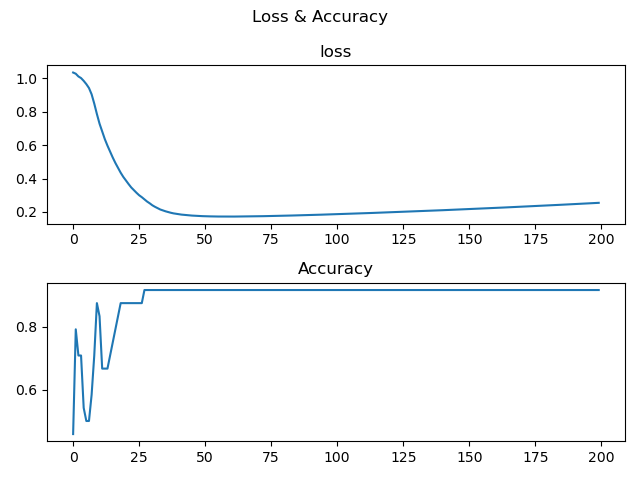

In [10]:
fig, ax = plt.subplots(2)
fig.suptitle('Loss & Accuracy')
ax[0].plot(epoch_list, test_loss_hist)
ax[0].set_title('loss')
ax[1].plot(epoch_list, test_acc_hist)
ax[1].set_title('Accuracy')
fig.tight_layout()
plt.show()

In [11]:
model.load_state_dict(torch.load('iris_model'))
model.eval()

Dlnn(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

### Testing Phase

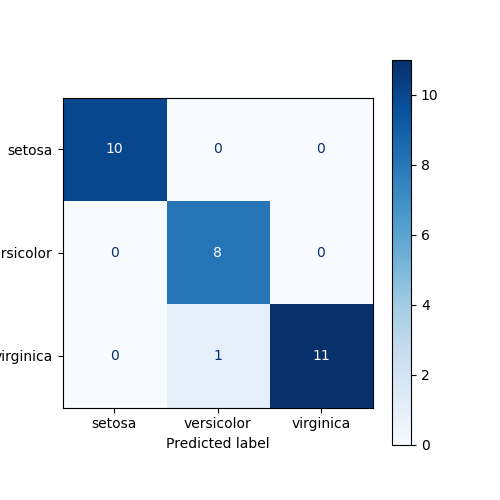

Test: Accuracy: 96.7%, Avg loss: 0.20997430632511774, Data Size: 30
done!


In [12]:
loss, accuracy = test_model(test, model, loss_fn, mode='test')
#display confusion matrix
print('done!')
